## Multivariate LSTM

# Import packages

In [484]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

from pandas_datareader import data as wb
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline

# Set figure parameters
plt.rcParams['figure.figsize'] = [10, 7.5]


# Input data

## FX

In [485]:
yf.pdr_override()

data = wb.get_data_yahoo('VND=x', start = '2014-01-01', end = '2024-12-31', interval = '1mo')

# Obtain latest vnd to usd rate
df_conv = wb.get_data_yahoo('VND=x', start = '2014-01-01', end = '2024-12-31')
data1 = 1/df_conv
vnd_to_usd = data1.iloc[-1,0]

# Summary statistics
df = pd.DataFrame(data['Adj Close']) 
df.rename(columns = {'Adj Close':'USDVND'}, inplace = True) 

diff = df.index.values[-1] - df.index.values[0]
months = diff.astype('timedelta64[M]')
years = int(months/12)
print("Total data: %d years" %years)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Total data: 10 years


## Vietnam GDP

In [486]:
vnd_gdp = pd.read_excel("Vietnam data.xlsx", sheet_name = 'GDP')
vnd_gdp['Date'] = pd.to_datetime(vnd_gdp['Date'])
vnd_gdp.set_index('Date', inplace = True)

In [487]:
# Upsample the data using linear interp
vnd_gdp_up = vnd_gdp.resample('MS').asfreq().interpolate(method='linear')

## FDI inflows

In [488]:
vnd_fdi = pd.read_excel("Vietnam data.xlsx", sheet_name = 'FDI')
vnd_fdi['Year'] = pd.to_datetime(vnd_fdi['Year'])
vnd_fdi.set_index('Year', inplace = True)

vnd_fdi.loc[:,'FDI inflow'] *= 1/vnd_to_usd

In [489]:
# Upsample the data using linear interp
vnd_fdi_up = vnd_fdi.resample('MS').asfreq().interpolate(method='linear')

# Prepare data

In [490]:
# Merge datasets on datetime
df.rename(columns = {'Adj Close':'USDVND'}, inplace = True) 
all_data = pd.merge(df,vnd_gdp_up, how='inner', left_index=True, right_index=True)

In [491]:
dataset = all_data.values
dataset = dataset.astype('float32')

In [492]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# separate into train and test data
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [493]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back= 3):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [494]:
# reshape input to be [samples, time steps, features]
n = 2 # number of columns
trainX = np.reshape(trainX, (trainX.shape[0], look_back, n))
testX = np.reshape(testX, (testX.shape[0], look_back, n))

# Build model

In [495]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, n)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=300, batch_size=16, verbose=1)

model.save('fundamental_model_eurusd_300epochs.h5')

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = np.squeeze(trainPredict)
testPredict = np.squeeze(testPredict)


def inverse_transform(arr):
    extended = np.zeros((len(arr), n))
    extended[:, 0] = arr
    return scaler.inverse_transform(extended)[:, 0]


trainPredict = inverse_transform(trainPredict)
testPredict = inverse_transform(testPredict)
trainY = inverse_transform(trainY)
testY = inverse_transform(testY)

Epoch 1/300


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4381
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3049 
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1877 
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0965 
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0732 
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0921 
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0890 
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0656 
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0585 
Epoch 10/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0769 
Epoch 11/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0570 
Epoch 12/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0667 
Epoch 13/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0767 
Epoch 14/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0537 
Epoch 15/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0580 
Epoch 16/300
5/5 ━━━━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


In [496]:
testY

array([23047.99896532, 23024.99953846, 23069.99989635, 23053.9988158 ,
       23044.99904007, 23019.99966305, 22964.99955435, 22774.99985121,
       22752.99892017, 22749.99899493, 22689.99901082, 22764.99862115,
       22644.99865293, 22819.99872985, 22853.99936186, 22955.99977862,
       23175.99873418, 23264.99947489, 23357.99863667, 23414.99869554,
       23819.99895809, 24819.99918634, 24749.99945142, 23600.00000253,
       23469.99880425, 23804.99933188, 23469.99880425, 23444.99942722,
       23480.00003431, 23568.99929577, 23684.99936366, 24109.99912783,
       24384.99967136, 24557.99979812, 24259.99982773])

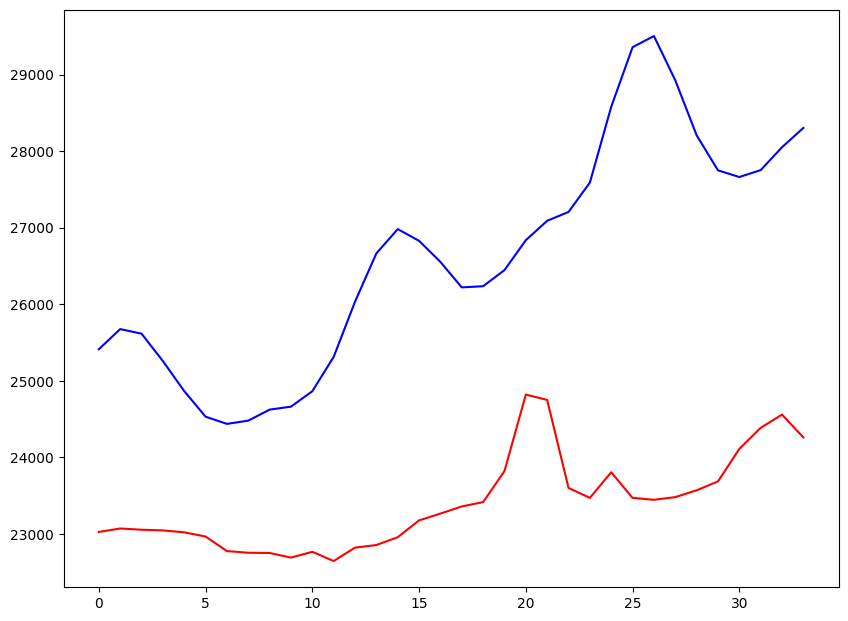

Test Score: 0.137669 RMSE


In [497]:
# shift predictions up by one
testPredict = np.delete(testPredict, -1)
testY = np.delete(testY, 0)

plt.plot(testPredict, color="blue")
plt.plot(testY, color="red")
plt.show()
testScore = np.sqrt(mean_squared_error(testY, testPredict))

testScore = testScore*vnd_to_usd

print('Test Score: %.6f RMSE' % (testScore))